## Import

In [1]:
import pandas as pd
import xlrd
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy.optimize as opt

## File name and experiment set-up

In [2]:
inhib_file = r'data\MOI 0.01 drug screen 2.xlsx'
tox_file = r'data\Uninfected nCoV drug screen 2.xlsx'
save_folder = r'out'
save_name = r'test'

## experiment set-up
n_plates = 7
n_columns = 12
n_repeats = 3
n_concentrations = 8
start_concentration = 50

## thresholds
tox_min_thresh = -30
tox_max_thresh = 30
inhib_min_thresh = -30
inhib_max_thresh = 200

## fitting options
force_curve_0 = True
force_max_100 = True

## Names of compounds

In [3]:
plate = {} # <--- don't change this line!
# format is plate[number]= ['Compound1', 'Compound2', 'Compound 3']
# e.g. plate[1] = ['FD', 'BM', 'AH']
# don't worry about dmso, that's already taken care of :)
plate[1] = ['FD', 'BM', 'AH']
plate[2] = ['CH', 'TC', 'AD']
plate[3] = ['TM', 'MH', 'T']
plate[4] = ['TV', 'A', 'GH']
plate[5] = ['IM', 'F', 'CH']
plate[6] = ['HS', 'PH', 'ED']
plate[7] = ['CP', 'TaC', 'H2O']
#
plate_names = plate # <--- don't change this line!

## Prepare array of concentrations

In [4]:
concentrations = []
concentrations.append(start_concentration)
for i in range(1, n_concentrations):
    concentrations.append(concentrations[i-1]/2)

## Function to read data from excel file into nice dictionary of dataframes

In [5]:
def get_dict_from_excel(filename, n_plates, n_columns, inhib=True):
    
    if not inhib:
        _n_plates = n_plates+1
    else:
        _n_plates = n_plates
    
    start_identifier = 'Plate:'
    end_identifier = '~End'
    
    book = xlrd.open_workbook(filename=filename)
    sheet = book.sheet_by_index(0)
    row_titles = sheet.col_values(0)
    
    start_indices = []
    end_indices = []
    
    for i in range(len(row_titles)):
        row_title = row_titles[i]
        if row_title==start_identifier:
            start_indices.append(i)
        elif row_title==end_identifier:
            end_indices.append(i)
    
    data = {}
    
    for plate in range(_n_plates):
        
        vals = []
        start = start_indices[plate]+2
        end = end_indices[plate]-1
        
        for col in range(2, 2+n_columns):
            cells = sheet.col_slice(col, start, end)
            for cell in cells:
                vals.append(cell.value)
        
        vals = np.reshape(vals, (n_columns, end-start)).T
        df = pd.DataFrame(data=vals)
        
        for i in range(n_concentrations):
            df.rename(index={i:concentrations[i]}, inplace=True)
           
        if not inhib:
            _plate = plate
        else:
            _plate = plate+1
        
        data[f'Plate {_plate}'] = df
        
    return data

## Function to do averaging of repeats

In [6]:
def do_repeat_averaging(df, n_repeats):
    
    n_columns = len(df.columns)
    col_names = df.columns
    
    n_samples = int(n_columns/n_repeats)
    
    df_averaged = pd.DataFrame()
       
    for n in range(n_samples):
        i = n*n_repeats
        j = (n+1)*n_repeats-1
        
        drug = col_names[i][:-2]

        _i = col_names[i]
        _j = col_names[j]
        av_col = df.loc[:,_i:_j].T.mean()
        std_col = df.loc[:,_i:_j].T.std()
        df_averaged[f'Mean {drug}'] = av_col
        df_averaged[f'Std {drug}'] = std_col

    return df_averaged

## Functions for toxicity and inhibition calculation

In [7]:
def get_toxicity(drug, cell, blank=0):
    
    _drug = np.subtract(drug, blank)
    _cell = np.subtract(cell, blank)

    tox = 1 - np.divide(_drug, _cell)
    
    return tox*100

In [8]:
def get_inhibition(drug, cell, vehicle):
    
    _drug = np.subtract(drug, vehicle)
    _cell = np.subtract(cell, vehicle)

    inhib = np.divide(_drug, _cell)
    
    return inhib*100

In [9]:
def get_tox_and_inhib_for_plate(inhib_data, tox_data, plate_number, plate_names, n_repeats, concentrations):
    plate_key = f'Plate {plate_number}'
    drug_names = plate_names[plate_number]
    n_drugs = len(drug_names)
    n_concentrations = len(concentrations)
    
    plate_0 = np.asarray(tox_data['Plate 0']).T
    inhib_array = np.asarray(inhib_data[plate_key]).T
    tox_array = np.asarray(tox_data[plate_key]).T
    
    cell = np.mean(plate_0)
    vehicle = np.mean(inhib_array[9:12], axis=0)
    
    df_inhib = pd.DataFrame()
    df_tox = pd.DataFrame()

    
    for d in range(n_drugs):
        drug = drug_names[d]
        
        for r in range(n_repeats):
            i = d*n_repeats + r

            tox = get_toxicity(tox_array[i], cell)
            inhib = get_inhibition(inhib_array[i], cell, vehicle)
            
            df_inhib[f'{drug}-{r+1}'] = inhib
            df_tox[f'{drug}-{r+1}'] = tox
           
    return df_tox, df_inhib        

## Logistic fitting

In [10]:
def logistic_function(x_vals, top, logEC50, hill_slope, bottom=0):
    x_vals = np.array(x_vals)
    x_vals = np.log10(x_vals)
    
    return bottom + (top-bottom)/(1+np.power(10, (logEC50-x_vals)*hill_slope))

def get_initial_conditions(array, concentrations, upper_bound, lower_bound):
    n = len(array)
    n_av = int(n/4)
    
    sorted_array = sorted(array)
    bottom_0 = np.mean(sorted_array[:n_av])
    top_0 = np.mean(sorted_array[-n_av:])
    
    half_val = (bottom_0+top_0)/2
    
    dist_to_half = []
    
    for i in range(n):
        v = array[i]
        dist = abs(v-half_val)
        dist_to_half.append([dist,i])
    
    dist_to_half = sorted(dist_to_half)[:n_av]
    
    av_c = 0
    sum_weight = 0
        
    for tup in dist_to_half:
        v = max(tup[0], 0.0001)
        i = tup[1]
        c = concentrations[i]
        av_c+=c/v
        sum_weight+=1/v
    
    if sum_weight is 0:
        ec_50 = 25
    else:
        ec_50 = av_c/sum_weight
    grad = (top_0-bottom_0)/(max(concentrations)-min(concentrations))
    
    params = [top_0, np.log10(ec_50), grad, bottom_0]
    params = np.amax([params, lower_bound], axis=0)
    params = np.amin([params, upper_bound], axis=0)
    
    return params

def sum_squared_residuals(coords, real_vals, *params):
    
    fitted = logistic_function(coords, *params)
        
    residuals = fitted - real_vals
    
    sum_squared_residuals = 0;
    
    for r in residuals:
        sum_squared_residuals += r**2
        
    return sum_squared_residuals


def r_squared(x, y, *params):
    
    fitted = logistic_function(x, *params)
    
    y_bar = np.mean(y)
    
    SStot = np.power(y-y_bar, 2)
    SStot = np.sum(SStot)

    SSreg = np.power(fitted-y_bar, 2)
    SSreg = np.sum(SSreg)
    
    return SSreg/SStot



def randomise_initial_conditions_and_fit(concentrations, responses, iterations, params, upper_bound, lower_bound):
    best_residual = np.inf
    best_params = params
    _params = [0,0,0,0]
    
    for i in range(iterations):
        
        _params[0] = params[0]
        _params[1] = np.random.normal(params[1], max(0.001, 0.05*params[1]))
        _params[2] = np.random.normal(params[2], max(0.001, 0.05*params[2]))
        _params[3] = params[3]
        
        try:
            popt, pcov = opt.curve_fit(logistic_function, concentrations, responses, p0=_params, bounds=(lower_bounds, upper_bounds))
        except:
            continue
                
        residual = sum_squared_residuals(concentrations, responses, *popt)
        
        if residual<best_residual:
            best_residual = residual
            best_params = popt
        
    r2 = r_squared(concentrations, responses, *best_params)
        
    return best_params, r2


def do_bounds():
    
    low_top = 0.
    hi_top = 100. if force_max_100 else 200.
    
    low_logec50 = 0.
    hi_logec50 = np.inf
    
    low_slope = 0.
    hi_slope = np.inf
    
    low_bottom = 0. if force_curve_0 else -100.
    hi_bottom = 0. if force_curve_0 else 90.
    
    lower_bound = [low_top, low_logec50, low_slope, low_bottom]
    upper_bound = [hi_top, hi_logec50, hi_slope, hi_bottom]
    
    return upper_bound, lower_bound



def fit_logistic_function(concentrations, responses, verbose=False):

    
    upper_bound, lower_bound = do_bounds()

    params = get_initial_conditions(responses, concentrations, upper_bound, lower_bound)

    popt, r2 = randomise_initial_conditions_and_fit(concentrations, responses, 10000, params, upper_bound, lower_bound)
    
    _top = popt[0]
    _logEC50 = popt[1]
    _hill_slope = popt[2]
    _bottom = popt[3]
    
    _x_vals = np.linspace(concentrations[0], concentrations[-1], 500)
    
    fit = logistic_function(_x_vals, _top, _logEC50, _hill_slope, _bottom)

    if verbose:
        print(f'Initialised params at: {params}')
        print(f'Optimised params at: {popt}')
        plt.figure()
        plt.plot(concentrations, responses, 'bo', label='raw data')
        plt.plot(_x_vals, fit, 'b', label='fit')
        plt.xscale('log')
    
    return _top, _logEC50, _hill_slope, _bottom, r2

## Plotting and fitting functions

In [11]:
def get_arrays(df, _i, _j, concentrations, min_thresh=None, max_thresh=None):

    concentrations = np.asarray(concentrations)
    _concentrations = np.tile(concentrations, n_repeats)
    
    array = np.asarray(df.loc[:,_i:_j].T)
    
    if min_thresh is not None or max_thresh is not None:
        _concentrations, array = purge_between_thresh(_concentrations, array, min_thresh, max_thresh)
    
    mean_array = np.nanmean(array, axis=0)
    std_array = np.nanstd(array, axis=0)
    array = array.flatten()
    
    concentrations = concentrations[~np.isnan(mean_array)]
    std_array = std_array[~np.isnan(mean_array)]
    mean_array = mean_array[~np.isnan(mean_array)]
    
    _concentrations = _concentrations[~np.isnan(_concentrations)]
    array = array[~np.isnan(array)]
            
    return array, mean_array, std_array, _concentrations, concentrations

def purge_between_thresh(x, y, min_thresh=None, max_thresh=None):
    
    shape = y.shape
    y = y.flatten()
    
    if min_thresh is not None:
        for i in range(len(y)):
            if y[i]<min_thresh:
                x[i] = None
                y[i] = None
                
    if max_thresh is not None:
        for i in range(len(y)):
            if y[i]>max_thresh:
                x[i] = None
                y[i] = None
    
    y = np.reshape(y, shape)
    
    return x, y
        
    
def plots_and_fits(df_tox, df_inhib, concentrations, n_repeats, t_min, t_max, i_min, i_max, plate=None, save_path=None):
    n_columns = len(df_tox.columns)
    col_names = df_tox.columns
    
    n_samples = int(n_columns/n_repeats)
    
    if save_path is not None:
        
        csvfile = open(f'.\{save_path}\{save_name}_plate_{plate}_fit_params.csv', 'w', newline='')
        csvwriter = csv.writer(csvfile, delimiter=',')
        csvwriter.writerow(['Drug', 'Bottom_T','Top_T', 'LogEC50_T', 'EC50_T', 'HillSlope_T', 'R2_T','Bottom_I', 'Top_I', 'LogEC50_I', 'EC50_I', 'HillSlope_I','R2_I'])
    
       
    for n in range(n_samples):
        
        i = n*n_repeats
        j = (n+1)*n_repeats-1
        
        drug = col_names[i][:-2]

        _i = col_names[i]
        _j = col_names[j]
        
        i_array, i_mean_array, i_std_array, i_concentrations_array, i_concentrations = get_arrays(df_inhib, _i, _j, concentrations, min_thresh=i_min, max_thresh=i_max)
        t_array, t_mean_array, t_std_array, t_concentrations_array, t_concentrations = get_arrays(df_tox, _i, _j, concentrations, min_thresh=t_min, max_thresh=t_max)
        
        if len(i_array)<2 and len(t_array)<2:
            print(f'VALUES FOR {drug} WERE ALL DODGY, SKIPPING')
        
        if len(i_array)>=2:
            i_t, i_e, i_h, i_b, i_r2 = fit_logistic_function(i_concentrations_array, i_array, verbose=False)
        else:
            i_t, i_e, i_h, i_b, i_r2 = [None, None, None, None, None]
            
        if len(t_array)>=2:
            t_t, t_e, t_h, t_b, t_r2 = fit_logistic_function(t_concentrations_array, t_array, verbose=False)
        else:
            t_t, t_e, t_h, t_b, t_r2 = [None, None, None, None, None]
        
        if save_path is not None:
            _t_e = None
            _i_e = None
            
            if t_e is not None:
                _t_e=10**t_e
                
            if i_e is not None:
                _i_e=10**i_e
        
            row = [drug, t_b, t_t, t_e, _t_e, t_h, t_r2, i_b, i_t, i_e, _i_e, i_h, i_r2]
            csvwriter.writerow(row)
        
        _x = np.linspace(concentrations[0], concentrations[-1], 1000)

        plt.figure(figsize=[5,5])
        
        plt.plot(i_concentrations_array, i_array, color='skyblue', marker='.', linestyle='')
        if len(i_array)>=2:
            plt.errorbar(i_concentrations, i_mean_array, i_std_array, color='skyblue', marker='o', linestyle='', capsize=3)
            plt.plot(_x, logistic_function(_x, i_t, i_e, i_h, i_b), color='dodgerblue')
        
        plt.plot(t_concentrations_array, t_array, color='coral', marker='.', linestyle='')
        if len(t_array)>=2:
            plt.errorbar(t_concentrations, t_mean_array, t_std_array, color='coral', marker='o', linestyle='', capsize=3)
            plt.plot(_x, logistic_function(_x, t_t, t_e, t_h, t_b), color='orangered') 
        
        plt.xscale('log')

        plt.ylim([-25, 125])
        plt.xlim([0.1, 100])
        plt.yticks(np.arange(-25, 125, 25),np.arange(-25, 125, 25))
        plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])
        plt.xlabel('Concentration (uM)')
        plt.ylabel('Percent (%)')
        plt.hlines([0,50,100], 0.1, 100, linestyle=':')
        plt.title(drug)
        
        if i_r2 is not None:
            plt.annotate(f'R2={i_r2:.3f}', xy=(0.2,90), color='dodgerblue')
        else:
            plt.annotate(f'No fit', xy=(0.2,90), color='dodgerblue')
        if t_r2 is not None:
            plt.annotate(f'R2={t_r2:.3f}', xy=(0.2,80), color='orangered')
        else:
            plt.annotate(f'No fit', xy=(0.2,80), color='orangered')
        
        if save_path is not None:
            plt.savefig(f'.\{save_path}\{save_name}_{drug}_plot.png', dpi=300)
            
    csvwriter.writerow([''])
    csvwriter.writerow(['-=-Settings-=-'])
    csvwriter.writerow([f'tox_low_thresh: {t_min}'])
    csvwriter.writerow([f'tox_high_thresh: {t_max}'])
    csvwriter.writerow([f'inhib_low_thresh: {i_min}']) 
    csvwriter.writerow([f'inhib_high_thresh: {i_max}'])
    csvwriter.writerow([f'Force_0: {force_curve_0}'])
    csvwriter.writerow([f'Force_max_100: {force_max_100}'])

c:\python366\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
c:\python366\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\python366\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


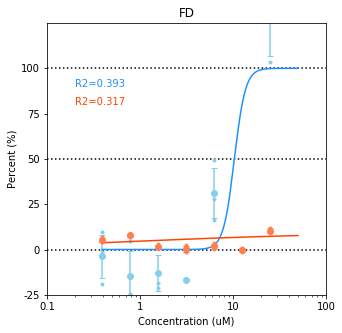

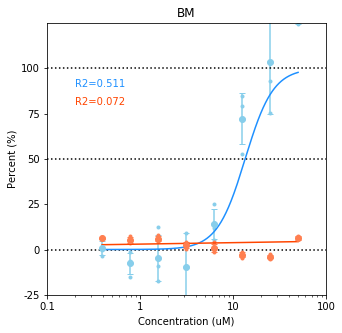

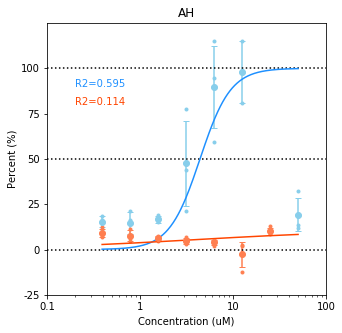

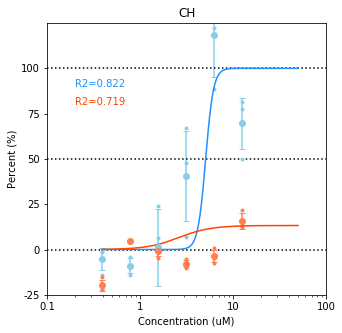

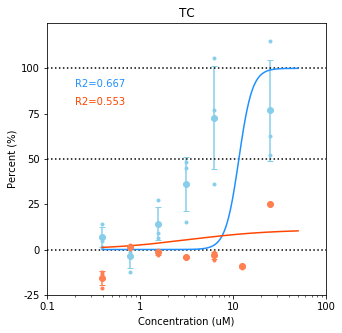

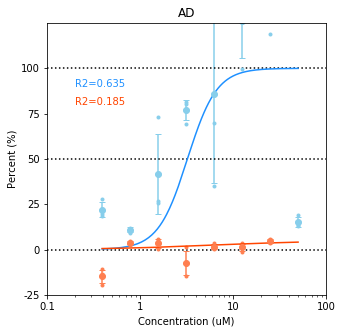

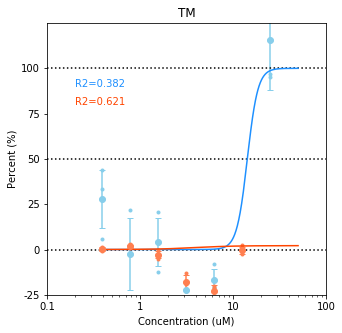

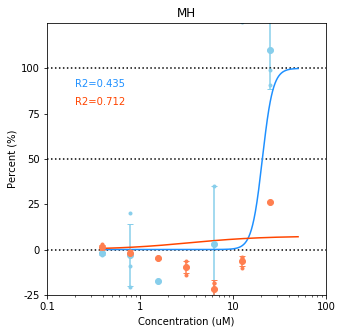

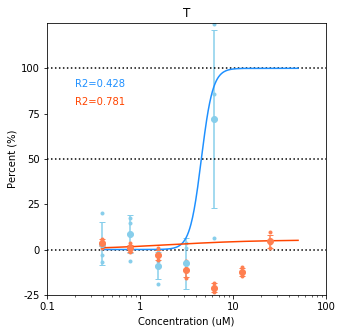

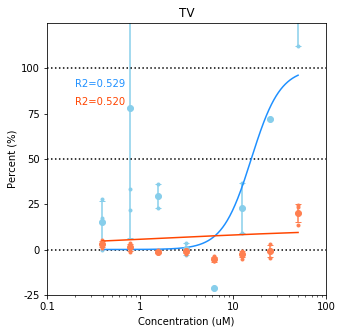

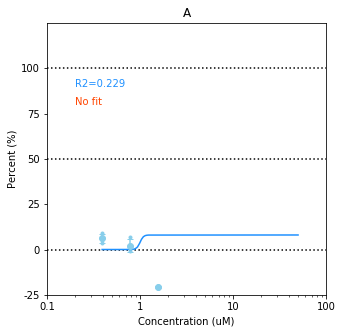

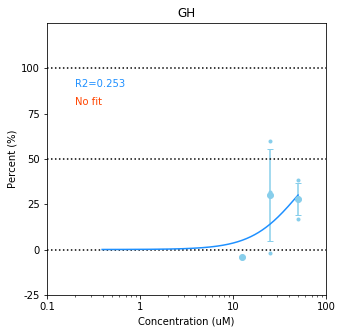

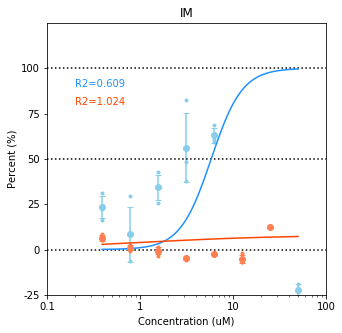

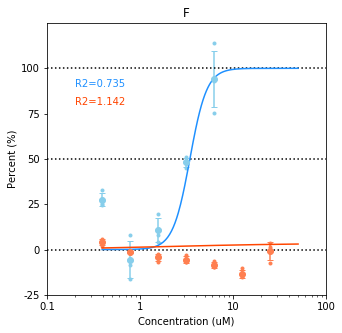

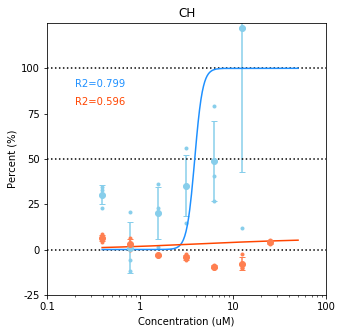

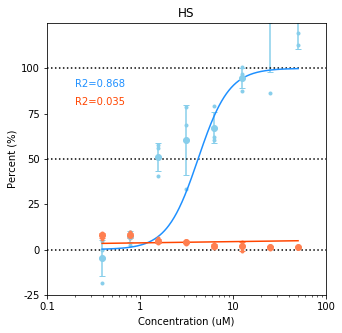

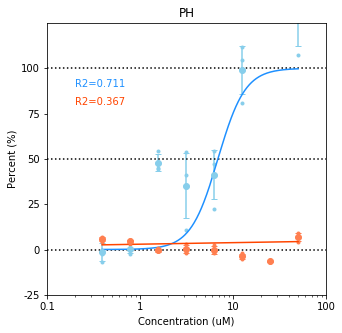

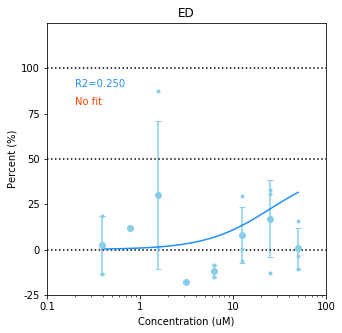

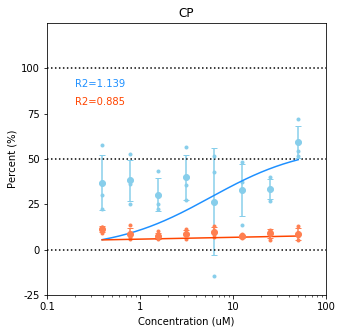

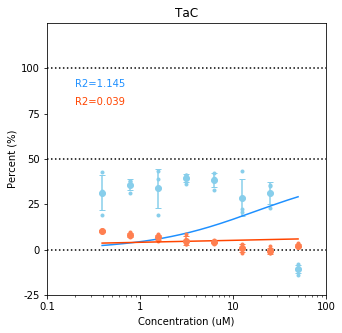

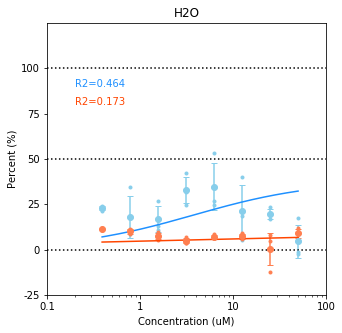

In [12]:
inhib_data = get_dict_from_excel(inhib_file, n_plates, n_columns)
tox_data = get_dict_from_excel(tox_file, n_plates, n_columns, inhib=False)

for plate in range(0, n_plates):

    df_tox, df_inhib = get_tox_and_inhib_for_plate(inhib_data, tox_data, plate+1, plate_names, n_repeats, concentrations)

    plots_and_fits(df_tox, df_inhib, concentrations, n_repeats, t_min=tox_min_thresh, t_max=tox_max_thresh, i_min=inhib_min_thresh, i_max=inhib_max_thresh, plate=plate+1, save_path=save_folder)